In [17]:
import community as cd
import igraph as ig
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 5.0)
matplotlib.rcParams.update({'font.size': 18})
import numpy as np
from collections import Counter, defaultdict
from operator import itemgetter
import random
import seaborn as sns
import powerlaw
import itertools
plt.style.use('ggplot')
import warnings

# Ignore two specific warning messages from the powerlaw package. 
# Comment these lines to show warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="divide by zero encountered in true_divide")

In [18]:
# read network as directed graph from edge list
G = pd.read_csv('clean_graph.csv', delimiter=",")

# Remove big subreddits that are in several communities
G = G[G.SOURCE_SUBREDDIT != 'askreddit']
G = G[G.SOURCE_SUBREDDIT != 'iama']
G = G[G.TARGET_SUBREDDIT != 'askreddit']
G = G[G.TARGET_SUBREDDIT != 'iama']

# Separate into negative and positive
DF_POS = G[G.LINK_SENTIMENT == 1]
DF_NEG = G[G.LINK_SENTIMENT == -1]

# Load into nx
G_POS = nx.convert_matrix.from_pandas_edgelist(DF_POS, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)
G_NEG = nx.convert_matrix.from_pandas_edgelist(DF_NEG, source="SOURCE_SUBREDDIT", target="TARGET_SUBREDDIT", edge_attr="LINK_SENTIMENT", create_using=nx.DiGraph)


# print summary of network
print(nx.info(G_NEG))

Name: 
Type: DiGraph
Number of nodes: 4863
Number of edges: 7463
Average in degree:   1.5346
Average out degree:   1.5346


In [19]:
# Replacing strings by integers to load into igraph
nodes = set(G.SOURCE_SUBREDDIT.unique()).union(set(G.TARGET_SUBREDDIT.unique()))
nodes_dict = dict(zip(nodes, range(len(nodes))))
label_dict = dict([(value, key) for key, value in nodes_dict.items()])

DF_NEG = DF_NEG.replace(to_replace=nodes_dict)
DF_POS = DF_POS.replace(to_replace=nodes_dict)

In [20]:
# Loading into igraph
igneg = ig.Graph.TupleList(DF_NEG.itertuples(index=False), directed=True, edge_attrs="weight")
igpos = ig.Graph.TupleList(DF_POS.itertuples(index=False), directed=True, edge_attrs="weight")
# Getting the largest strongly connected component
negbc = igneg.components().giant()
posbc = igpos.components().giant()
'''
Doing infomap for community detection.
Wanted to use the fast greedy algorithm, which merges individual nodes into communities in a way that greedily maximizes the modularity score of the graph.
I thought it would be a really good idea for our realtively large network, but it has no support for directed graphs (story of our lives))
'''
negvertex = negbc.community_infomap(trials=20)
posvertex = posbc.community_infomap(trials=20)

In [21]:
# Plotting the biggest strongly connected components
def plotcommunity(graph, name):
    visual_style = dict()
    layout = graph.layout_fruchterman_reingold()
    visual_style["layout"] = layout
    visual_style["bbox"] = (5000, 5000)
    visual_style["margin"] = 100
    #graph.vs['label'] = label_dict[graph.vs['name']]
    #visual_style["vertex_label"] = graph.vs['label']
    visual_style["vertex_label"] = [label_dict[x] for x in graph.vs["name"]]
    out = ig.plot(graph, **visual_style)
    out.save(name + '.png')

In [61]:
posvertex20 = posbc.community_infomap(trials=20)

In [73]:
posvertex102 = posbc.community_infomap(trials=10)

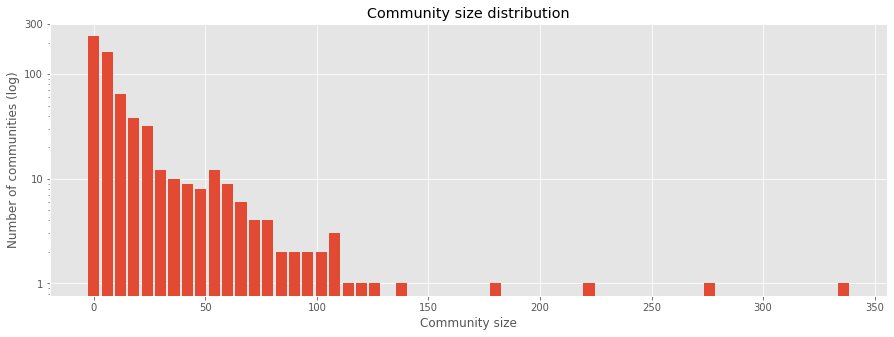

In [202]:
xs, ys = zip(*[(left, count) for left, _, count in posvertex102.size_histogram(bin_width=6).bins()])
plt.bar(xs, ys, width=5,log=1)
plt.xlabel("Community size")
plt.ylabel("Number of communities (log)")
plt.title("Community size distribution")
plt.yticks([1,10,100,300], labels=[1,10,100,300])
plt.savefig("communitySizeDistribution.png")
plt.show()


TypeError: object of type 'zip' has no len()

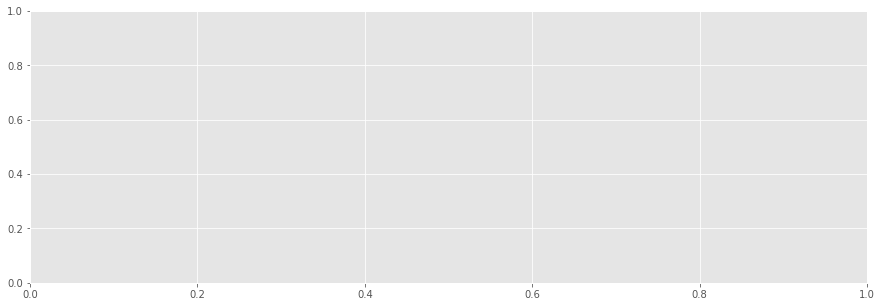

In [112]:
n,x, _ = plt.hist(zip(*[(left, count) for left, _, count in posvertex.size_histogram().bins()]), bins = 20)
plt.close()
bin_centers = 0.5*(x[1:]+x[:-1])
plt.gca().set_yscale("symlog", linthresh=0.001)
plt.scatter(bin_centers,n)
plt.title('Out degree centrality distribution')
plt.xlabel('C_d_out')
plt.ylabel('P(C_d_out)')
plt.show()
print(max(email_out_degree_cent.values()))

In [ ]:
def testplot(graph, name):
    visual_style = dict()
    pal = ig.drawing.colors.ClusterColoringPalette(len(negvertex))
    negbc.vs['color'] = pal.get_many(negvertex.membership)
    layout = negbc.layout_fruchterman_reingold()
    visual_style["layout"] = layout
    visual_style["bbox"] = (5000, 5000)
    visual_style["margin"] = 100
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(graph, **visual_style,
                       vertex_label = vertex_labels)
    out.save(name + '.png')
    
testplot(negbc, "negative_component")

In [80]:
posvertex

In [25]:
# Positive components
ss = posvertex.sizes() 
second = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[1]))
third = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[2]))
fourth = posvertex.subgraph(ss.index(sorted(ss, reverse=True)[3]))

In [34]:
len([x for x in third.es])

888

In [26]:
#Plots
plotcommunity(posvertex.giant(), "test1st")
plotcommunity(second, "test2nd")
plotcommunity(third, "test3rd")
plotcommunity(fourth, "test4th")

In [9]:
#Negative components
ss = negvertex.sizes() 
second = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[1]))
third = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[2]))
fourth = negvertex.subgraph(ss.index(sorted(ss, reverse=True)[3]))

In [10]:
plotcommunity(negvertex.giant(), "N1st")
plotcommunity(second, "N2nd")
plotcommunity(third, "N3rd")
plotcommunity(fourth, "N4th")

In [128]:
# Probably not useful
neg_labels = [label_dict[x] for x in [n for n in negbc.vs['name']]]
pos_labels = [label_dict[x] for x in [n for n in posbc.vs['name']]]

In [24]:
# Maybe use later
'''
# Gave labels and names to the nodes so we could maybe visualize something in Gephi
vm = negvertex.membership
for i in range(len(negbc.vs)):
    negbc.vs[i]["label"] = new_dict[negbc.vs[i]["name"]]
    negbc.vs[i]["name"] = vm[i]
'''


In [25]:
# Output for Gephi - Maybe use later
'''
f = "bigcomponent.graphml"
negbc.write(f, format="graphml")
'''

In [28]:
# Tried getting the 20 biggest communities in the biggest connected component. Didn't work... Igraph continues to elude me
'''
def func(g):
    return g.__sizeof__()

new_vertex = sorted(negvertex.subgraphs(), key=func, reverse=True)[:20]
'''

In [29]:
# Tried doing colors for only the top 20 communities... Igraph has bested me again
'''
colorset = set()
for v in new_vertex:
    for a in v.vs:
        colorset.add(a.attributes()["label"])
#vertex.subgraphs()[0].vs[0].attributes()["label"]

vm = negvertex.membership
for i in range(len(vm)):
    if i not in colorset:
        vm[i] = 500
'''

In [34]:
# Plotting the biggest strongly connected negative component
def testplot(graph, name):
    visual_style = dict()
    pal = ig.drawing.colors.ClusterColoringPalette(len(negvertex))
    negbc.vs['color'] = pal.get_many(negvertex.membership)
    layout = negbc.layout_fruchterman_reingold()
    visual_style["layout"] = layout
    visual_style["bbox"] = (5000, 5000)
    visual_style["margin"] = 100
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(graph, **visual_style,
                       vertex_label = vertex_labels)
    out.save(name + '.png')
    
testplot(negbc, "negative_component")

In [52]:
# Plotting the biggest strongly connected positive component
def testplot(graph, name):
    visual_style = dict()
    pal = ig.drawing.colors.ClusterColoringPalette(len(posvertex))
    posbc.vs['color'] = pal.get_many(posvertex.membership)
    layout = posbc.layout_fruchterman_reingold()
    visual_style["layout"] = layout
    visual_style["bbox"] = (5000, 5000)
    visual_style["margin"] = 100
    graph.vs['label'] = graph.vs['name']
    out = ig.plot(graph, **visual_style,
                       vertex_label = vertex_labels)
    out.save(name + '.png')
    
testplot(posbc, "positive_component")

In [33]:
# Setting community number to 200 if community not in the top 20 biggest to try to visualize the largest communities
most = set([x for x,y in dic.most_common(20)])
v = negvertex.membership
for i in range(len(v)):
    if v[i] not in most:
        v[i] = 200

AttributeError: 'dict' object has no attribute 'most_common'